## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [56]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [57]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [58]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [59]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [60]:
df['converted'].sum()
converted = df['converted'].sum()/df['user_id'].nunique()
converted

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [61]:
df1 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')") 
df1.count()[0]

3893

f. Do any of the rows have missing values?

In [62]:
df.isnull().sum()[0]

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [63]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")
df2.shape

(290585, 5)

In [64]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [65]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [66]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [67]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [68]:
time_del = '2017-01-14 02:55:59.590927'
df2 = df2[df2.timestamp != time_del]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [69]:
df2.user_id.nunique()

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [70]:
df2.query('converted == 1').count()[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [71]:
control = df2.query('group == "control"')
control.query('converted == 1').count()[0]/control.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [72]:
treatment = df2.query('group == "treatment"')
treatment.query('converted == 1').count()[0]/treatment.shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [73]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

1. As per the calculations, conversion rate for the control group is higher than the treatment group but the differene between the two is negligible. Also, these conversion rates are almost equal to the mean conversion rate which implies that the old page is better. This requires further proof through hypothesis testing and boot sampling.

2. Since the probability of receiving both the pages, old and new is the same, this has no impact on our conversion rates.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_{0}:  p_{old}  >=  p_{new}$$

$$H_{1}:  p_{new}  > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [74]:
new_p = df2['converted'].mean()
new_p

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [75]:
old_p = df2['converted'].mean()
old_p

0.11959708724499628

c. What is $n_{new}$?

In [76]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [77]:
len_new = df2.query('landing_page == "new_page"').count()[3]
len_new

145310

d. What is $n_{old}$?

In [78]:
len_old = df2.query('landing_page == "old_page"').count()[3]
len_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [79]:
new_page_converted = np.random.choice([0, 1], size=len_new, p=[1-new_p, new_p])
new_page_converted.mean()

0.12013626040878123

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [80]:
old_page_converted = np.random.choice([0, 1], size=len_old, p=[1-old_p, old_p])
old_page_converted.mean()

0.11911284882360229

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [81]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.001023411585178935

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [82]:
p_diffs = []

for _ in range(10000):
    sample_new = np.random.choice([0, 1], size=len_new, p=[1-new_p, new_p], replace=True)
    sample_new.mean()
    sample_old = np.random.choice([0, 1], size=len_old, p=[1-old_p, old_p], replace=True)
    sample_old.mean()
    p_diffs.append(sample_new.mean() - sample_old.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

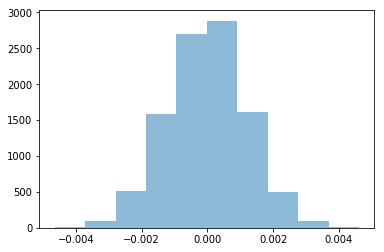

In [83]:
p_diffs = np.array(p_diffs)   # convert the list to numpy array
plt.hist(p_diffs, alpha=0.5); # plot the difference distribution

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [97]:
#compute actuall difference
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
act_diff

-0.0015782389853555567

In [98]:
#compute the p value
p_val = (act_diff < p_diffs).mean()
p_val

0.9048

In [84]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

1. p-value is defined as the probaiblity of obtaining the observed statistic or one or more extreme in favor of the alternative hypothesis, if the null hypothesis is true.

2. The decision to reject or to not to reject the null hypothesis comes from comparing the p-value with the Type I error rate ($\alpha$):
$$p-value <= \alpha$$
$$p-value > \alpha$$

3. We conclude from our analysis that the p-value for the distribution is greater than the Type I error rate (0.89 > 0.05) and hence we will not reject the null hypothesis. Also, the conversion rates are similar for old and new pages.  The conlcusion drawn from the anlysis is to keep the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [89]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [100]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [101]:
convert_old

17489

In [102]:
convert_new

17264

In [103]:
n_old

145274

In [104]:
n_new

145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [108]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [106]:
#Tells us how significant our z-score is
norm.cdf(z_score)

0.9050583127590245

In [107]:
#Tells us what our critical value at 95% confidence interval is
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score of 1.31 is less than the critical value of 1.96, we fail to reject the null hypothesis. Even the p-value is higher than the Type I error rate. These findings agree with our conclusions drawn in the previous parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [109]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [110]:
df2['treatment'] = pd.get_dummies(df2['group'])['treatment']
df2 = df2.rename(columns={'treatment':'ab_page'})
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [111]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)

df2['intercept'] = 1
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [112]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:20:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.190. This value differs from the value that we got in Part II as it was a one-tailed test and the regression analysis is two-tailed test.**

Hypotheses for the regression model:
$$H_{0}:  p_{old}  =  p_{new}$$

$$H_{1}:  p_{new}  \neq   p_{old}$$


Convert a two-tailed test to one-tailed test:
To get the p-value from two-tailed test to one-tailed test, we first divide the p-value of ab_page (0.190/2 = 0.095) and then the p-value is (1 - 0.095 = 0.905). 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**1. The advantage of using regression models is that it allows us to take an individual approach to recommendations. For instance we can add courses, increase the runtime and gather more data to see effect on the conversion rate. We can also check the relationship between region and conversion.**

**2. Regression analysis will help provide a more quantitative support for decisions as A/B Testing can produce bias results when tested on exiting users due to 'change aversion' or 'novelty effect'.**

**Disadvantages of adding additional terms into the regression model:**
- Non-linearity of the response-predictor relationships: A true relationship might not exist between the respone and the predictor variable.
- Multicollinearity: Additionally, the explonatory predictor variables might be correlated and this might weaken the coefficient estimates. The coefficients become sensitive to small changes. We migh also observe flipped relationships between the predictor variable and the response.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [113]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [114]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])[['UK', 'US', 'CA']]
df_new.tail()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA
user_id,,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,0,1,0,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,0,1,1,0,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,0,1,1,0,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,0,0,1
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,0,1,1,0,0


In [115]:
country_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'CA']])
results1 = country_mod.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 12 Jul 2018   Pseudo R-squ.:               1.521e-05
Time:                        20:43:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5052   1.36e+05  -1.11e-05      1.000   -2.67e+05    2.67e+05
UK            -0.4816   1.36e+05  -3.54e-06      1.000   -2.67e+05    2.67e+05
US            -0.4915   1.36e+05  -3.61e-06      1.000   -2.67e+05    2.67e+05
CA            -0.5323   1.36e+05  -3.91e-06      1.000   -2.67e+05    2.67e+05
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [116]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results2 = log_mod.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        20:43:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [117]:
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [118]:
1/np.exp(results2.params)

intercept    7.614303
ab_page      1.015056
UK           0.950621
US           0.960062
dtype: float64

In [119]:
df_new.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

<a id='conclusions'></a>
## Conclusions

1. Here again the p-values are greater than 0.05(Type I error rate), therefore they are not significant to the model  and hence we fail to reject the null hypotheis
2. For each 1 unit decrease in ab_page, conversion is 1.02 times as likely, holding all else constant.
3. A/B Testing and Regression Models recommend that we fail to reject the null hypothesis.